In [396]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import warnings

warnings.filterwarnings("ignore")
warnings.filterwarnings('ignore', category=DeprecationWarning)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
pd.options.display.float_format = '{:.2f}'.format


**Início da Análise**

In [397]:
# Conectando ao banco de dados
db_path = './Dados/olist.sqlite'
db_connection = sqlite3.connect(db_path)

In [398]:
# Função para visualizar as tabelas
def consulta_simples(table, limit):
    query = f"""
        SELECT *
        FROM {table}
        LIMIT {limit}
    """
    return pd.read_sql_query(query, db_connection)

In [399]:
consulta_simples('orders', 5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [400]:
encomendas_por_dia = """
SELECT
    DATE(order_purchase_timestamp) AS dia,
    COUNT(*) AS count_pedidos
FROM orders
GROUP BY dia
"""

df = pd.read_sql_query(encomendas_por_dia, db_connection)
df.head(5)

,dia,count_pedidos
0,2016-09-04,1
1,2016-09-05,1
2,2016-09-13,1
3,2016-09-15,1
4,2016-10-02,1


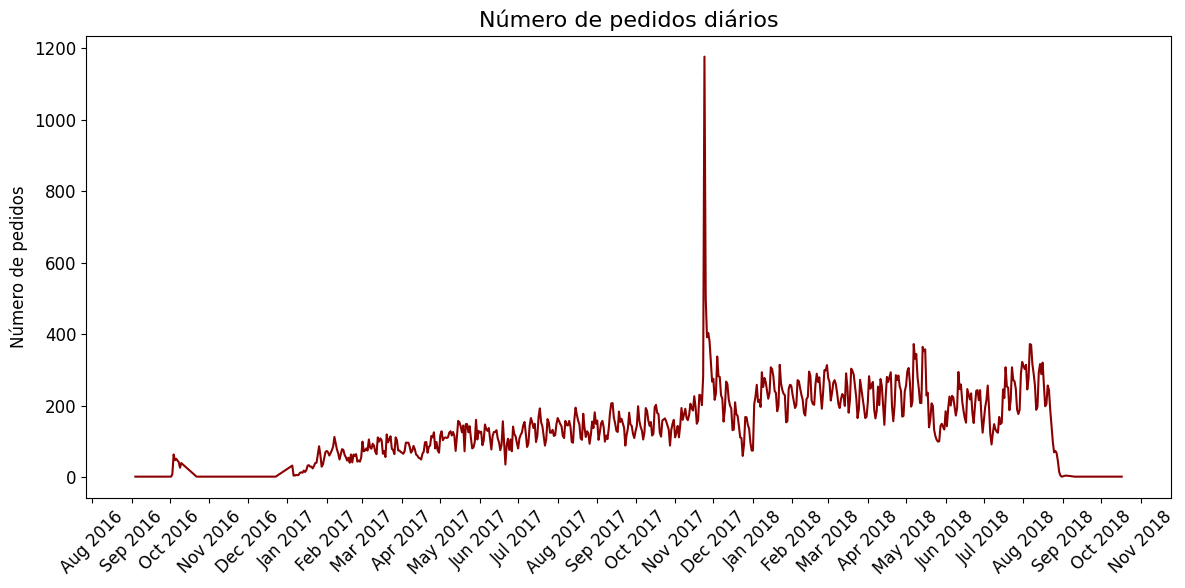

In [401]:
import matplotlib.dates as mdates

plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16

plt.figure(figsize=(14, 6))
plt.plot(pd.to_datetime(df['dia']), df['count_pedidos'], linestyle='-', color='darkred')
plt.ylabel('Número de pedidos')
plt.title('Número de pedidos diários')
# Ajustar os rótulos do eixo x
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.show()

**Verificando a distribuição dos pedidos ao longo da semana e das horas do dia.**

In [402]:
encomendas_por_dia_e_hora = """
SELECT
    -- Dias da semana abreviados
    CASE STRFTIME('%w', order_purchase_timestamp)
        WHEN '1' THEN 'Seg'
        WHEN '2' THEN 'Ter'
        WHEN '3' THEN 'Qua'
        WHEN '4' THEN 'Qui'
        WHEN '5' THEN 'Sex'
        WHEN '6' THEN 'Sab'
        WHEN '0' THEN 'Dom'
        END AS dia_da_semana,
    -- Dias da semana como inteiro (Domingo=7)
    CAST(STRFTIME('%w', order_purchase_timestamp) AS INTEGER) AS dia_da_semana_int,
    -- Hora do dia (0-24)
    CAST(STRFTIME("%H", order_purchase_timestamp) AS INTEGER) AS hora
FROM orders
"""

pd.read_sql_query(encomendas_por_dia_e_hora, db_connection)


,dia_da_semana,dia_da_semana_int,hora
0,Seg,1,10
1,Ter,2,20
2,Qua,3,8
3,Sab,6,19
4,Ter,2,21
...,...,...,...
99436,Qui,4,9
99437,Ter,2,12
99438,Dom,0,14
99439,Seg,1,21


In [403]:
# Gerando consultas SQL para contagem de pedidos por hora
contagem_pedidos_por_hora = ',\n    '.join([
    f'COUNT(CASE WHEN hora = {i} THEN 1 END) AS "{i}"' \
    for i in range(24)
])

pedidos_por_dia_da_semana_e_hora = f"""
WITH PedidosPorHora AS (
    {encomendas_por_dia_e_hora}
)

SELECT
    dia_da_semana,
    {contagem_pedidos_por_hora}
FROM PedidosPorHora
GROUP BY dia_da_semana_int
ORDER BY dia_da_semana_int
"""

In [404]:
print(pedidos_por_dia_da_semana_e_hora[591:])

ELECT
    dia_da_semana,
    COUNT(CASE WHEN hora = 0 THEN 1 END) AS "0",
    COUNT(CASE WHEN hora = 1 THEN 1 END) AS "1",
    COUNT(CASE WHEN hora = 2 THEN 1 END) AS "2",
    COUNT(CASE WHEN hora = 3 THEN 1 END) AS "3",
    COUNT(CASE WHEN hora = 4 THEN 1 END) AS "4",
    COUNT(CASE WHEN hora = 5 THEN 1 END) AS "5",
    COUNT(CASE WHEN hora = 6 THEN 1 END) AS "6",
    COUNT(CASE WHEN hora = 7 THEN 1 END) AS "7",
    COUNT(CASE WHEN hora = 8 THEN 1 END) AS "8",
    COUNT(CASE WHEN hora = 9 THEN 1 END) AS "9",
    COUNT(CASE WHEN hora = 10 THEN 1 END) AS "10",
    COUNT(CASE WHEN hora = 11 THEN 1 END) AS "11",
    COUNT(CASE WHEN hora = 12 THEN 1 END) AS "12",
    COUNT(CASE WHEN hora = 13 THEN 1 END) AS "13",
    COUNT(CASE WHEN hora = 14 THEN 1 END) AS "14",
    COUNT(CASE WHEN hora = 15 THEN 1 END) AS "15",
    COUNT(CASE WHEN hora = 16 THEN 1 END) AS "16",
    COUNT(CASE WHEN hora = 17 THEN 1 END) AS "17",
    COUNT(CASE WHEN hora = 18 THEN 1 END) AS "18",
    COUNT(CASE WHEN hora =

In [405]:
df = pd.read_sql_query(pedidos_por_dia_da_semana_e_hora, db_connection)
df = df.set_index('dia_da_semana')
display(df)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
dia_da_semana,,,,,,,,,,,,,,,,,,,,,,,,
Dom,267,141,69,44,27,27,34,105,205,349,531,721,678,723,684,716,712,797,895,899,967,889,873,607
Seg,328,134,66,36,21,22,69,160,479,783,1035,1078,971,1027,1096,1079,1094,992,928,945,1027,1118,991,717
Ter,306,158,80,28,29,24,71,223,522,864,967,1056,898,1045,1124,1047,1081,967,877,924,988,1027,965,692
Qua,397,179,81,33,33,27,93,211,517,829,1042,1062,919,1029,1050,983,1040,967,852,848,904,963,878,615
Qui,355,167,75,39,31,28,85,220,502,758,984,960,983,986,977,928,1077,909,784,826,839,840,857,551
Sex,426,216,72,49,40,36,97,206,493,768,956,990,855,1002,961,979,974,817,723,784,738,726,702,512
Sab,315,175,67,43,25,24,53,106,249,434,662,711,691,706,677,722,697,701,710,756,730,654,550,429


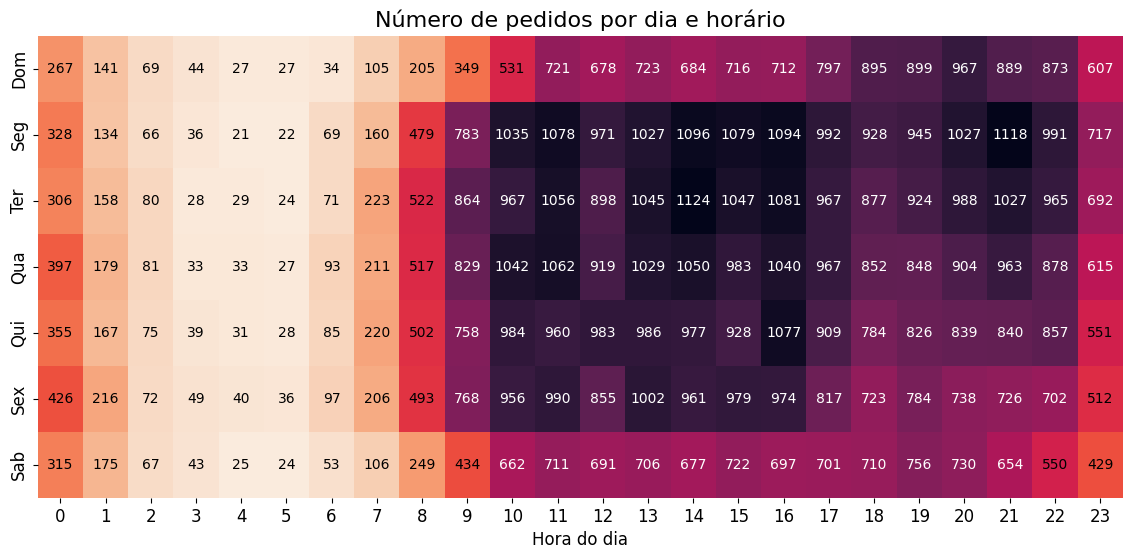

In [406]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.heatmap(df, cmap='rocket_r', cbar=False)
media_encomendas = df.mean().mean()
for i in range(len(df)):
    for j in range(len(df.columns)):
        text_color = 'white' if df.iloc[i, j] > media_encomendas else 'black'
        ax.text(j+0.5, i+0.5, int(df.iloc[i, j]),
            color=text_color, fontsize=10, ha="center", va="center")
plt.title("Número de pedidos por dia e horário")
plt.xlabel("Hora do dia")
plt.ylabel("")
plt.show()

O gráfico heatmap acima, mostra que a maioria dos pedidos foram realizados de segunda a sexta, em horário comercial, entre as 10:00h e 17:00h e de domingo a quarta-feira das 20:00h às 22:00h. Verificamos também um leve queda nas vendas por volta de meio dia.

Os picos de vendas ocorrem normalmente as segundas por volta das 14 e 21 horas, e as terças, também as 14 horas.

**Investigando a localização geográfica dos pedidos**

In [407]:
consulta_simples('customers', 5)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [408]:
# Gerando consultas SQL para contagem de pedidos por cidade
pedidos_por_cidade = """
SELECT 
    customer_city AS cidade_cliente,
    UPPER(customer_city) AS cidade,
    COUNT(orders.order_id) AS contagem_pedidos_cidade
FROM 
    customers
    JOIN orders USING (customer_id)
GROUP BY customer_city
ORDER BY contagem_pedidos_cidade DESC
LIMIT 10
"""

pd.read_sql_query(pedidos_por_cidade, db_connection)

,cidade_cliente,cidade,contagem_pedidos_cidade
0,sao paulo,SAO PAULO,15540
1,rio de janeiro,RIO DE JANEIRO,6882
2,belo horizonte,BELO HORIZONTE,2773
3,brasilia,BRASILIA,2131
4,curitiba,CURITIBA,1521
5,campinas,CAMPINAS,1444
6,porto alegre,PORTO ALEGRE,1379
7,salvador,SALVADOR,1245
8,guarulhos,GUARULHOS,1189
9,sao bernardo do campo,SAO BERNARDO DO CAMPO,938


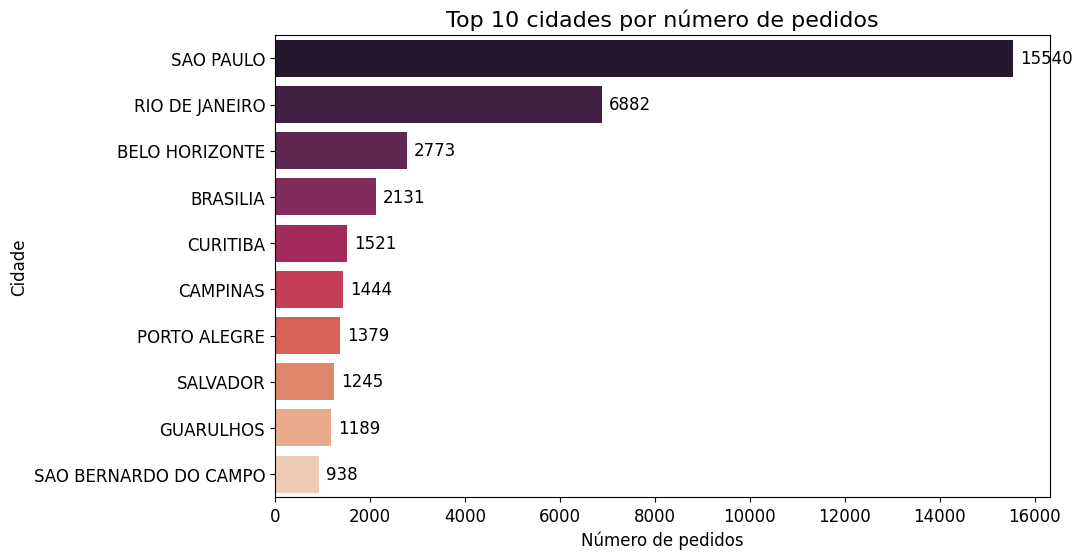

In [411]:
# Executar a consulta SQL e armazenar o resultado em um DataFrame
top_cities = pd.read_sql_query(pedidos_por_cidade, db_connection)

# Criar a figura e os eixos
plt.figure(figsize=(10, 6))

# Criar o gráfico de barras horizontais com Seaborn
ax = sns.barplot(x='contagem_pedidos_cidade', y='cidade', data=top_cities, palette='rocket', orient='h')

# Adicionar título e rótulos aos eixos
plt.title('Top 10 cidades por número de pedidos')
plt.xlabel('Número de pedidos')
plt.ylabel('Cidade')

# Adicionar os valores no final das barras
for p in ax.patches:
    ax.annotate(format(p.get_width(), '.0f'), 
                (p.get_width(), p.get_y() + p.get_height() / 2.), 
                va='center', xytext=(5, 0), textcoords='offset points')

# Exibir o gráfico
plt.show()